<a href="https://colab.research.google.com/github/rudycav/Equities-Digital-Assets-Prediction-Model/blob/main/Project/%20Ethereum_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import numpy as np
import math
import tensorflow
import requests
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [90]:
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' E7KN41UXPEIKWXIK'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)', 'open', 'high', 'low', 'volume'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

eth_df = get_crypto_price(symbol = 'ETH', exchange = 'USD', start_date = '2016-01-01')
eth_df.head()

,close
Date,
2019-10-16,174.47
2019-10-17,177.16
2019-10-18,172.74
2019-10-19,171.79
2019-10-20,175.22


In [91]:
eth_df.shape

(1000, 1)

In [92]:
def scale_data(scaler):
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(eth_df.close.values.reshape(-1,1))

  return scaled_data, scaler

scaled_data, scaler = scale_data(eth_df)

In [93]:
def prediction(scaled_data):
  
  x_train, y_train = [], []

  for days in range(60, len(scaled_data)-28):
    x_train.append(scaled_data[days-60: days, 0])
    y_train.append(scaled_data[days+28, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)

  return x_train, y_train

x_train, y_train = prediction(scaled_data)


In [94]:
x_train_reshape = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [95]:
x_train.shape

(912, 60)

In [96]:
def neural_network(x_train, y_train, epochs, batch_size):

  model = Sequential()

  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_reshape.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(x_train_reshape, y_train, epochs, batch_size)
 
  return model

neural_network = neural_network(x_train_reshape, y_train, epochs=25, batch_size=32)

Epoch 1/32
37/37 [==============================] - 16s 72ms/step - loss: 0.0406
Epoch 2/32
37/37 [==============================] - 3s 69ms/step - loss: 0.0201
Epoch 3/32
37/37 [==============================] - 2s 67ms/step - loss: 0.0184
Epoch 4/32
37/37 [==============================] - 3s 69ms/step - loss: 0.0171
Epoch 5/32
37/37 [==============================] - 2s 67ms/step - loss: 0.0181
Epoch 6/32
37/37 [==============================] - 3s 70ms/step - loss: 0.0170
Epoch 7/32
37/37 [==============================] - 3s 73ms/step - loss: 0.0160
Epoch 8/32
37/37 [==============================] - 3s 76ms/step - loss: 0.0164
Epoch 9/32
37/37 [==============================] - 2s 67ms/step - loss: 0.0156
Epoch 10/32
37/37 [==============================] - 2s 67ms/step - loss: 0.0152
Epoch 11/32
37/37 [==============================] - 2s 67ms/step - loss: 0.0158
Epoch 12/32
37/37 [==============================] - 3s 68ms/step - loss: 0.0145
Epoch 13/32
37/37 [=================

In [97]:

test_data = get_crypto_price(symbol='ETH', exchange='USD', start_date = '2016-07-10')
closing_prices = test_data.close.values
merged_dataset = pd.concat((eth_df.close, test_data.close),axis=0)


In [98]:
def create_test_model(merged_dataset):
  new_model = merged_dataset[len(merged_dataset) - len(test_data) - 60:].values
  new_model = new_model.reshape(-1, 1)
  new_model = scaler.fit_transform(new_model)

  return new_model

test_model = create_test_model(merged_dataset)


In [107]:
def create_test_set(new_model):

  x_test = []

  for days in range(60, len(new_model)):
    x_test.append(new_model[days-60: days, 0])

  x_test = np.array(x_test)

  return x_test

x_test = create_test_set(test_model)

In [108]:
x_test_reshape = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [109]:
predict = neural_network.predict(x_test_reshape)
predict = scaler.inverse_transform(predict)

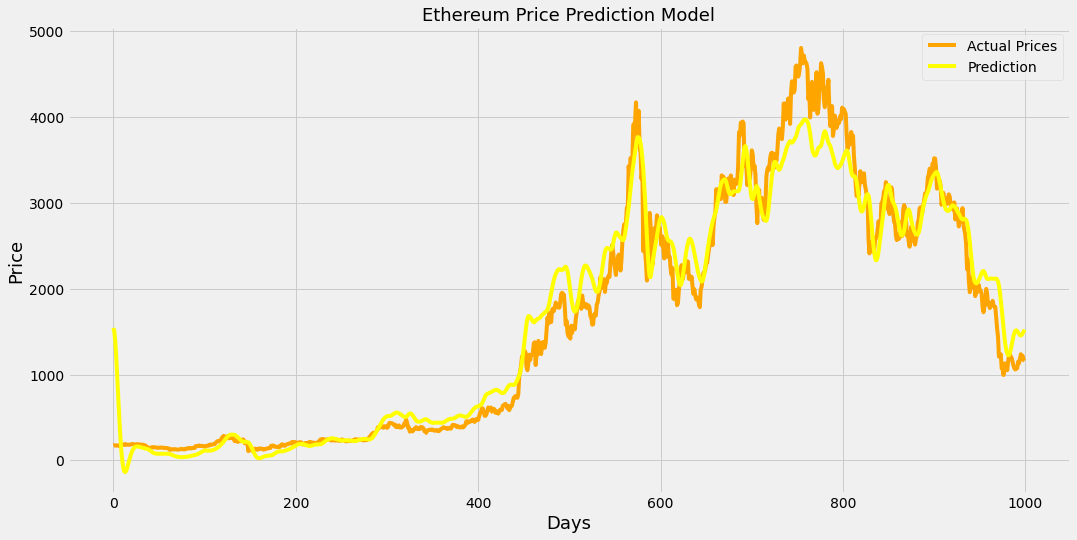

In [110]:

plt.figure(figsize=(16,8))
plt.plot(closing_prices, color='orange', label = 'Actual Prices')
plt.plot(predict, color='yellow', label = 'Prediction')
plt.title('Ethereum Price Prediction Model', fontsize=18)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='upper right')

plt.show()

In [111]:
predict_df = pd.DataFrame(predict, columns=['Price'])
predict_df.index.name = 'Days'
             
predict_df

,Price
Days,
0,1543.445190
1,1502.576538
2,1393.195679
3,1227.396484
4,1025.097656
...,...
995,1455.425903
996,1462.484863
997,1479.029785


In [127]:
past_days = eth_df[-60:].values
pred_scaled_data = scaler.transform(past_days)

pred_x_test = []
pred_x_test.append(pred_scaled_data)
pred_x_test = np.array(pred_x_test)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1], 1))

forecast = neural_network.predict(pred_x_test)
forecast = scaler.inverse_transform(forecast)
forecast

array([[1543.4451]], dtype=float32)